# Import the needed libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
from IPython.display import Markdown, display
import gc
import time
from functools import partial

In [2]:
%matplotlib inline

In [3]:
color = sns.color_palette()

In [4]:
warnings.simplefilter("ignore")

In [5]:
def printmd(string):
    display(Markdown(string))

In [6]:
def get_unique_count(x):
    return len(np.unique(x))

# Data Loading

In [7]:
order_products_train = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [8]:
printmd('**The shape of all the input files :-**')
printmd(f'The order_products_train size is :\n{order_products_train.shape}')
printmd(f'The order_products_prior size is :\n{order_products_prior.shape}')
printmd(f'The orders size is :\n{orders.shape}')
printmd(f'The products size is :\n{products.shape}')
printmd(f'The aisles size is :\n{aisles.shape}')
printmd(f'The departments size is :\n{departments.shape}')

**The shape of all the input files :-**

The order_products_train size is :
(1384617, 4)

The order_products_prior size is :
(32434489, 4)

The orders size is :
(3421083, 7)

The products size is :
(49688, 4)

The aisles size is :
(134, 2)

The departments size is :
(21, 2)

# Data Preprocessing

## <font color=blue> - Data View</font>

In [9]:
order_products_train.head(5)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [11]:
print('Total orders: {}'.format(products.shape[0]))
orders.head(5)

Total orders: 49688


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [12]:
print('Total products: {}'.format(products.shape[0]))
products.head(5)

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [13]:
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head(5)

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [14]:
print('Total departments: {}'.format(departments.shape[0]))
departments.head(5)

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## <font color=blue> - Checking for null values in each tables</font>

In [15]:
order_products_train.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [16]:
order_products_prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [17]:
orders.isnull().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [18]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [19]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [20]:
departments.isnull().sum()

department_id    0
department       0
dtype: int64

## <font color=blue> - Feature Creation </font>

##### Concatenate the Orders_products_train and Order_products_prior table as both contains purchased products order of customers

In [21]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)
order_products_all.head()

The order_products_all size is :  (33819106, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


##### Merging the product + aisles + departments details with the order_products_prior details

In [22]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


##### Merging the order + product + aisles + departments details with the order_products_train details

In [23]:
order_products_train = pd.merge(order_products_train, orders, on='order_id', how='left')
order_products_train = pd.merge(order_products_train, products, on='product_id', how='left')
order_products_train = pd.merge(order_products_train, aisles, on='aisle_id', how='left')
order_products_train = pd.merge(order_products_train, departments, on='department_id', how='left')
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


##### Merging these product + departments + aisles details and creating the items table

In [24]:
items  = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


## <font color=blue> - Data Analysis </font>

### Get the count of rows in each of the three csv files - prior, train and test

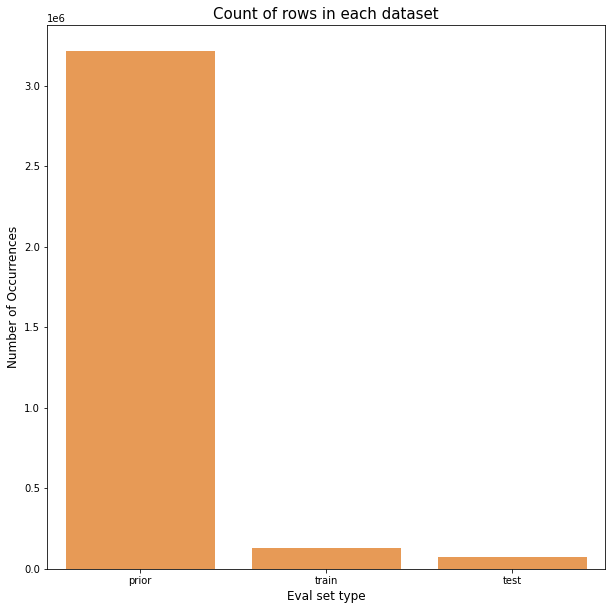

In [25]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(10,10))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()

##### There are 206,209 customers in total. 
##### Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

In [26]:
cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

### There are no more than 4 to 100 orders of a customer

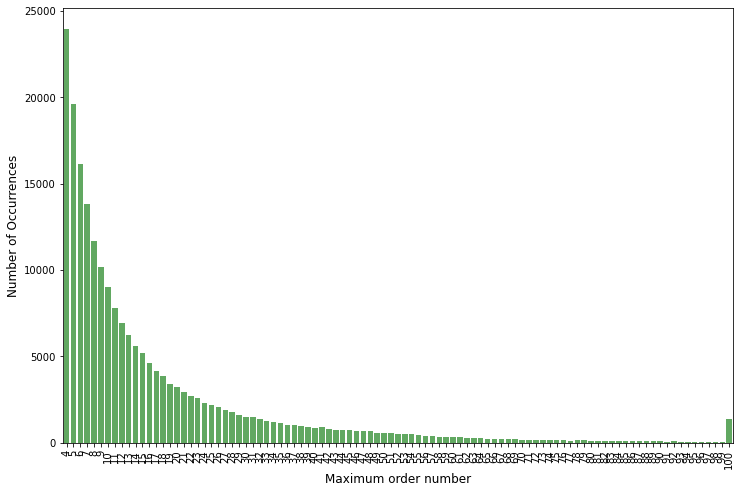

In [27]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

### Let us see how the ordering habit changes with day of week

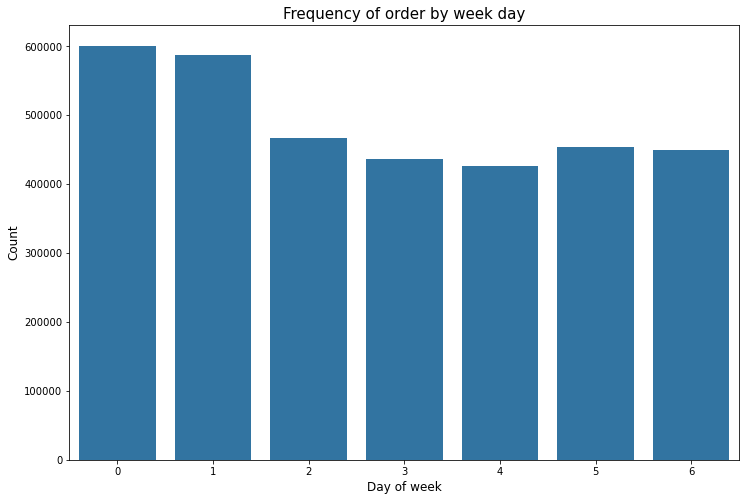

In [28]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='horizontal')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

##### Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday

### Now we shall see how the distribution is with respect to time of the day

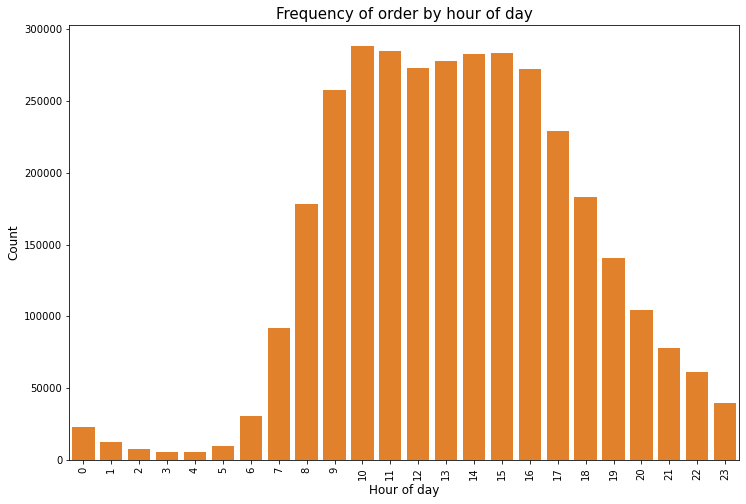

In [29]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

##### So majority of the orders are made during day time. 

### Now let us combine the day of week and hour of day to see the distribution

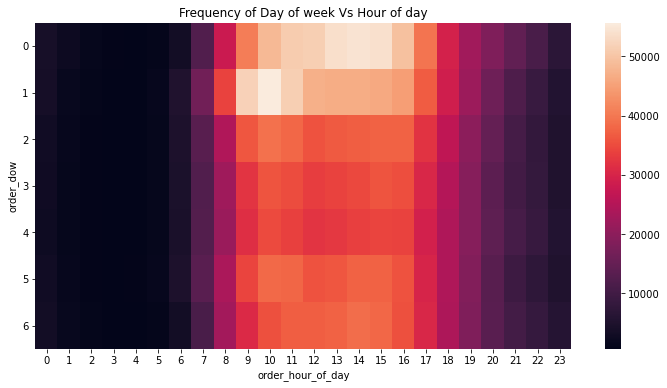

In [30]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.yticks(rotation='horizontal')
plt.show()

##### Seems Satuday evenings and Sunday mornings are the prime time for orders.

### Now let us check the time interval between the orders.

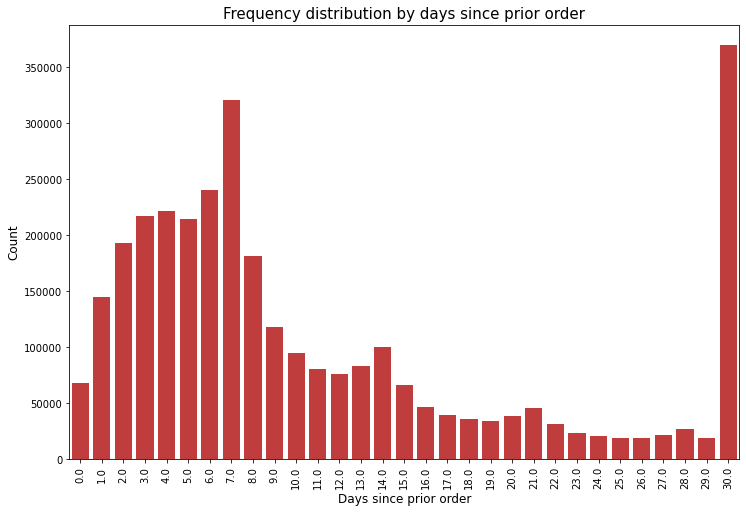

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

##### Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). 
      We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

### Now let us see the number of products bought in each order.

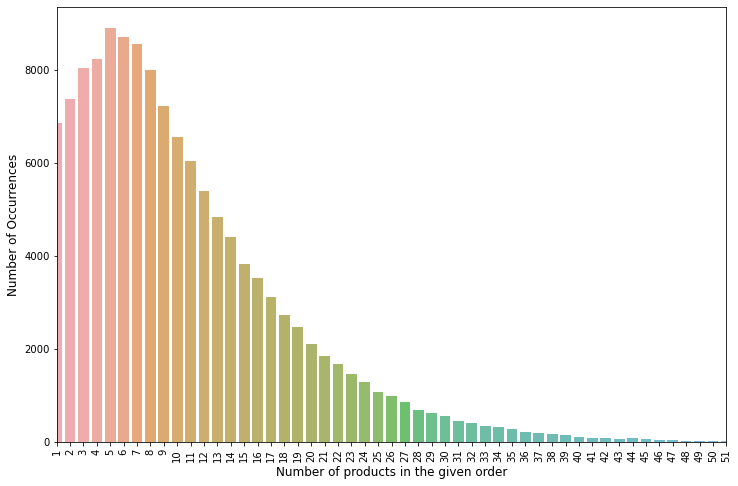

In [32]:
grouped_df = order_products_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.xlim([0, 50])
plt.show()

##### Most common order contains: 5 products

### Plot departments volume, split by aisles

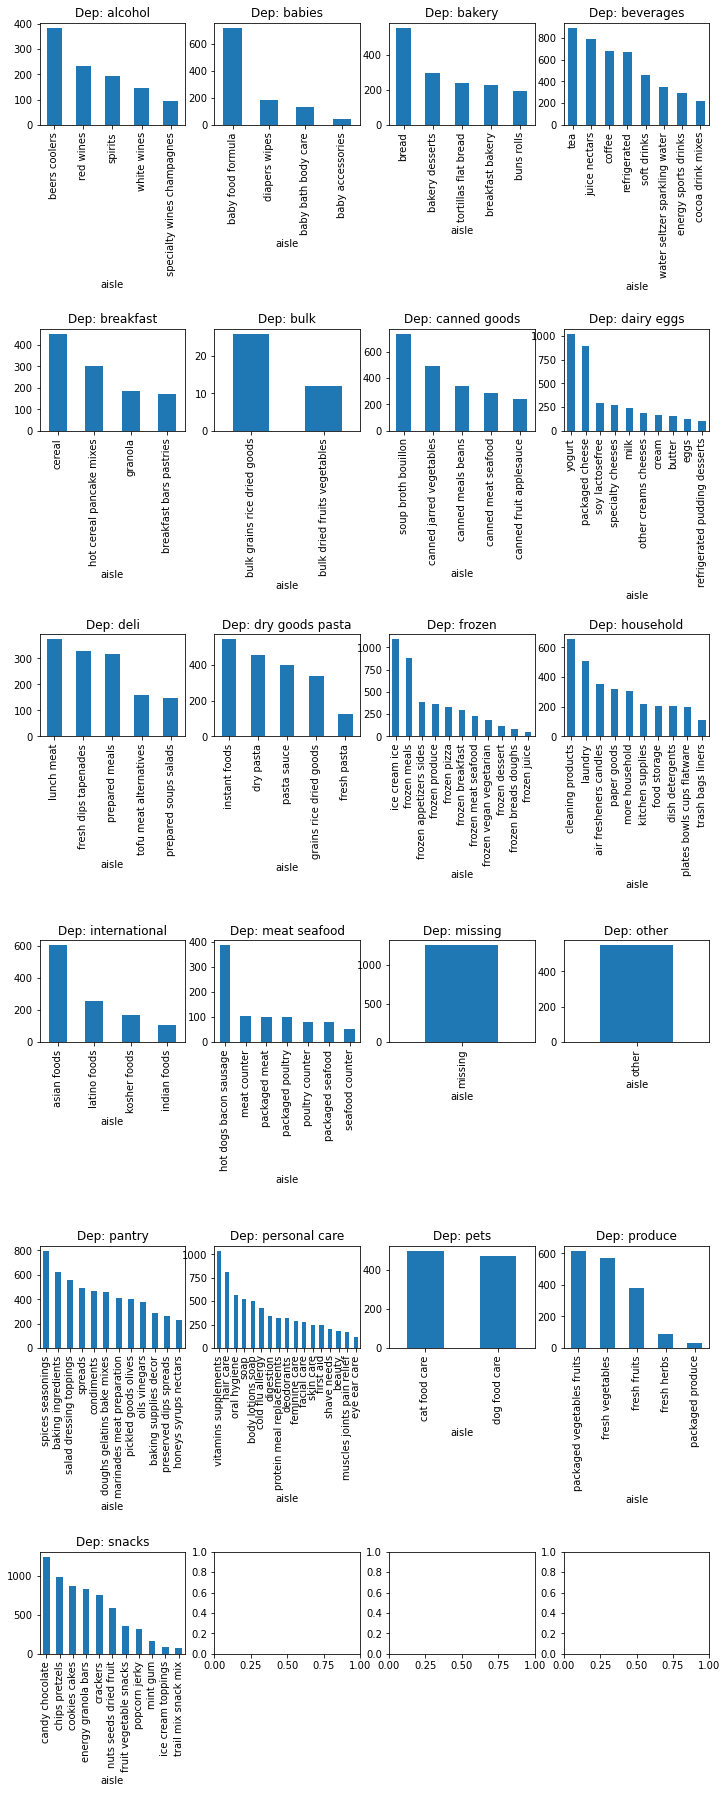

In [33]:
items.product_name = items.product_name.str.replace(' ', '_').str.lower() 

items.head()
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    items[items.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

#### Popular Products (Bestsellers)

In [34]:
cnt_srs = order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


##### Most of them are organic products.! Also majority of them are fruits.

### Now let us look at the important aisles.

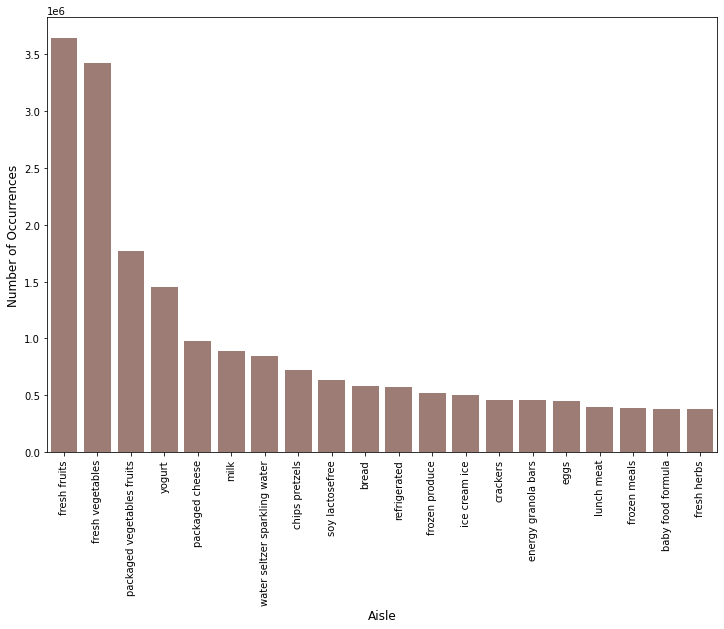

In [35]:
cnt_srs = order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

##### The top two aisles are fresh fruits and fresh vegetables.!

### Let us now check the department wise distribution.

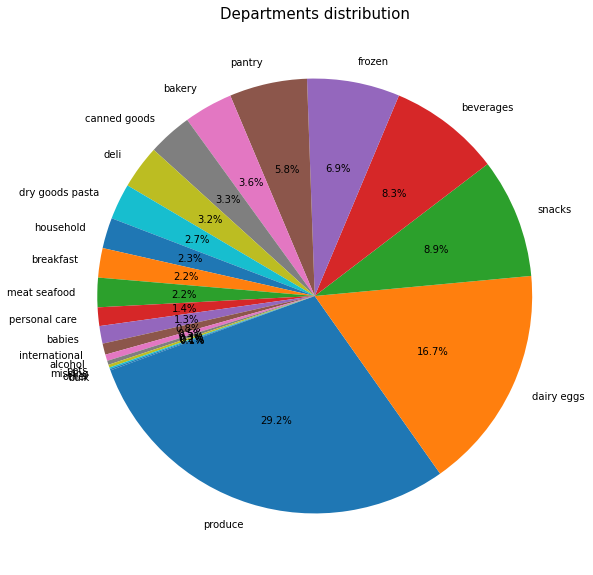

In [36]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

##### Produce is the largest department

### % of Orders count of Organic and non-organic products

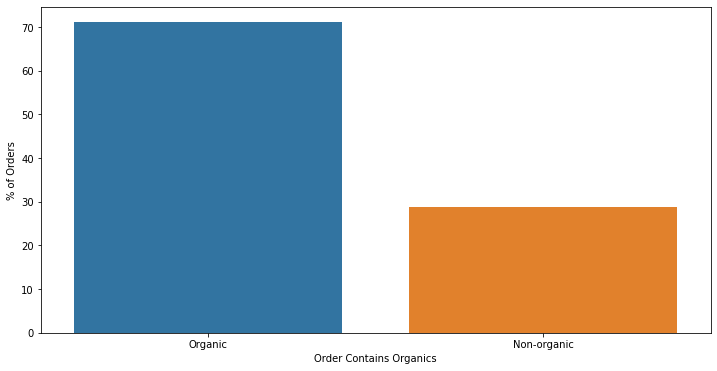

In [60]:
org = pd.merge(
    left=order_products_train[['product_id', 'order_id']],
    right=items[['product_id', 'product_name']],
    how='left',
    on='product_id')

org['organic'] = org.product_name.str.contains('organic').astype(np.int8)
org['organic'] = org['organic'].map({0: 'Non-organic', 1: 'Organic'})
org = org.groupby('order_id')['organic'].aggregate("max").value_counts()

# plot it
plt.figure(figsize=(12, 6))
sns.barplot(org.index, org / org.sum() * 100)
plt.xticks(rotation='horizontal')
plt.xlabel('Order Contains Organics')
plt.ylabel('% of Orders')
pass

# Since our objective is to figure out the re-orders

### Let us check out the re-order product percentage

### In prior set 

In [38]:
order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

### In train set

In [39]:
order_products_train.reordered.sum() / order_products_train.shape[0]

0.5985944127509629

##### On an average, about 59% of the products in an order are re-ordered products.

### Let us check out the No re-ordered products percentage

###- In prior set

In [40]:
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df = grouped_df.reordered.value_counts() / grouped_df.shape[0]
grouped_df[0]

0.12084859313304347

### In train set

In [41]:
grouped_df = order_products_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df = grouped_df.reordered.value_counts() / grouped_df.shape[0]
grouped_df[0]

0.06555952716658156

##### About 12% of the orders in prior set has no re-ordered items while in the train set it is 6.5%.

### Department wise reorder ratio:

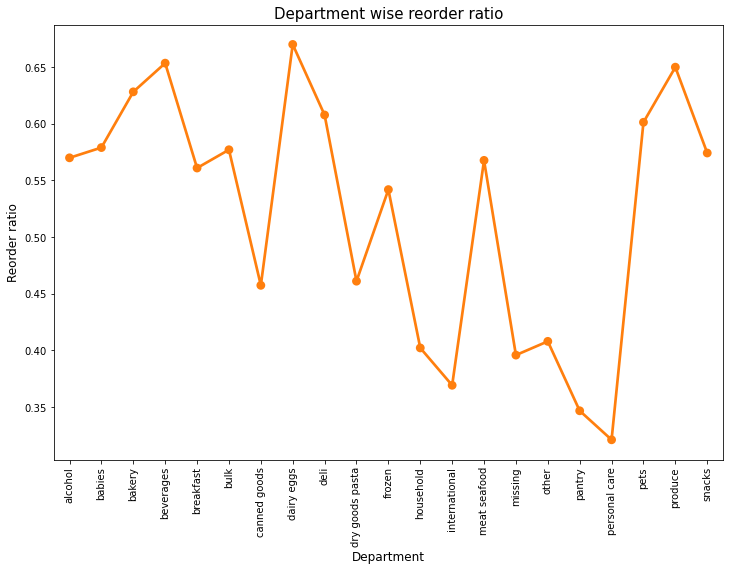

In [57]:
grouped_df = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

#### Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

### Aisle - Reorder ratio:

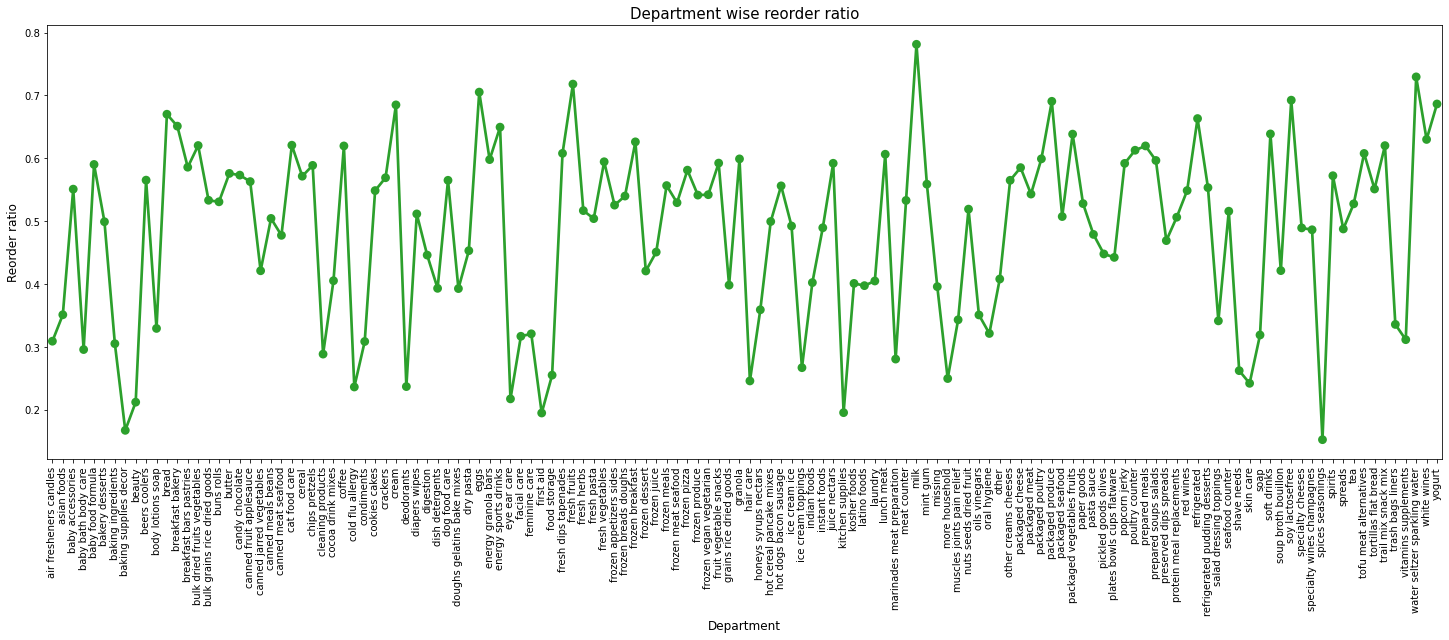

In [55]:
grouped_df = order_products_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()


plt.figure(figsize=(25,8))
sns.pointplot(grouped_df['aisle'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Aisle wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


### Let us check the relationship between how order of adding the product to the cart affects the reorder ratio

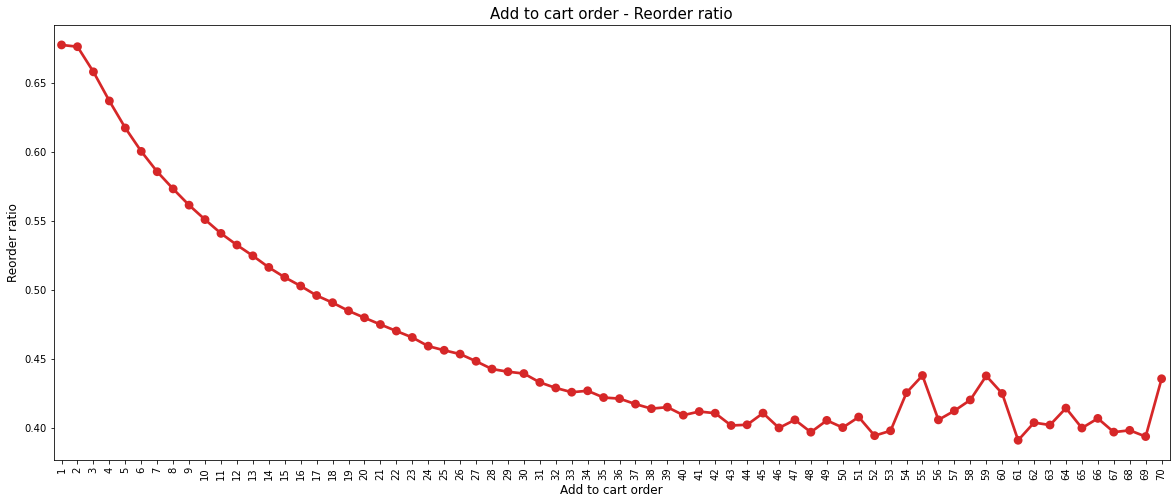

In [58]:
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(20,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

##### Looks like the products that are added to the cart initially are more likely to be reordered again compared to the ones added later. 
This makes sense to me as well since we tend to first order all the products we used to buy frequently and then look out for the new products available.

### Reorder ratio with day of week

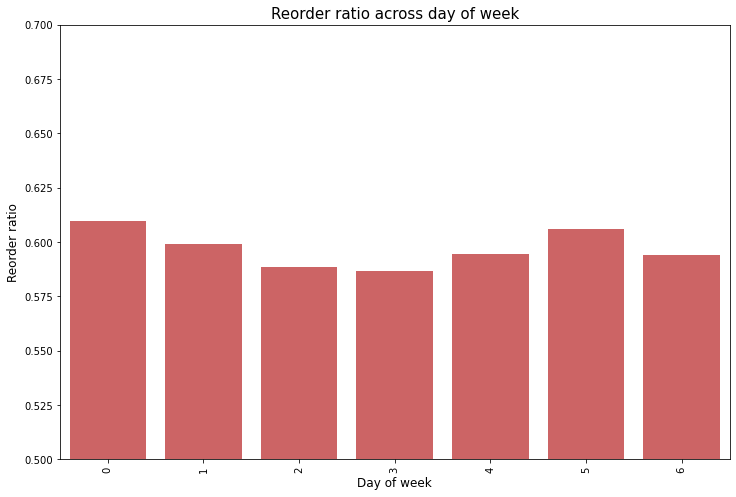

In [45]:
grouped_df = order_products_train.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

### Reorder ratio with respect to time of the day

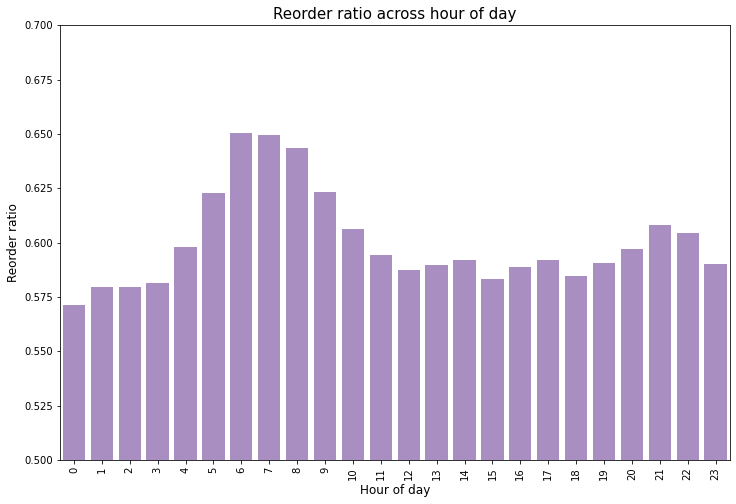

In [46]:
grouped_df = order_products_train.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

### Now let us combine Reordered data of the day of week and hour of day to see the distribution

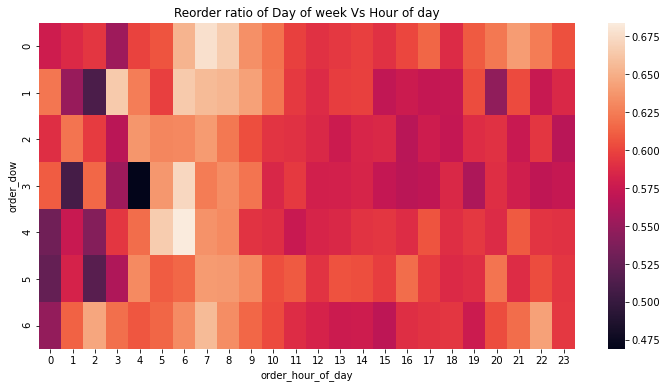

In [47]:
grouped_df = order_products_train.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()

##### Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

In [48]:
gc.collect()

5259